In [1]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
%matplotlib inline

In [2]:
np.random.seed(1573)

In [3]:
def f(x,a=1,b=0,e=5,curve_deg=5):
    x = np.array(x)
    y = a*x+b+e*np.random.randn(x.shape[0])
    curve = np.polyfit(x=x, y=y, deg=curve_deg)
    return lambda x: np.polyval(p=curve, x=x)

In [4]:
T = 9
x = np.linspace(-5,5,100)
curves = [f(x) for _ in range(T)]

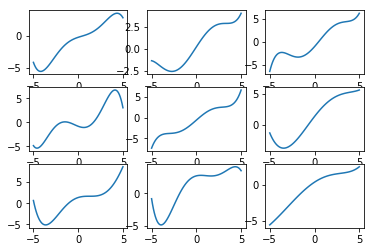

In [5]:
for i in range(T):
    plt.subplot(3, 3, i+1)
    plt.plot(x,curves[i](x))

In [6]:
X = np.array(list(itertools.product(np.linspace(-5,5,100),np.linspace(-5,5,100))))

In [7]:
D = [(X,np.int32(X[:,1]<=curve(X[:,0]))) for curve in curves]

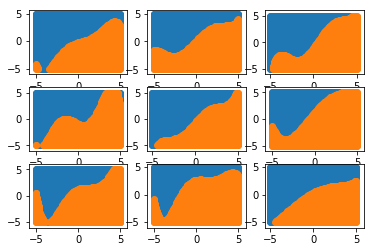

In [8]:
for i,d in enumerate(D):
    x,y = d
    plt.subplot(3, 3, i+1)
    plt.scatter(x[y==0,0],x[y==0,1])
    plt.scatter(x[y==1,0],x[y==1,1])

In [9]:
observed_domain_idx = [0,1,2,3,4,5,6,7]
held_out_domain_idx = [8]

In [10]:
import tensorflow as tf

In [11]:
sess = tf.InteractiveSession()

In [12]:
n_input = 2
n_output = 2
n_hidden = 50

In [13]:
param_list = [tf.Variable(tf.truncated_normal(shape=[n_input, n_hidden], stddev=0.01)),
              tf.Variable(tf.zeros(shape=[n_hidden])),
              tf.Variable(tf.truncated_normal(shape=[n_hidden, n_output], stddev=0.01)),
              tf.Variable(tf.zeros(shape=[n_output]))]

In [14]:
def nn(x, W0, b0, W1, b1):
    h = tf.nn.xw_plus_b(x, W0, b0)
    a = tf.nn.relu(h)
    o = tf.nn.xw_plus_b(a, W1, b1)
    return o

In [15]:
X_placeholder = tf.placeholder(tf.float32, shape=[None, n_input])
Y_placeholder = tf.placeholder(tf.int32, shape=[None])

In [16]:
trnX = np.concatenate([D[i][0] for i in observed_domain_idx], axis=0)
trnY = np.concatenate([D[i][1] for i in observed_domain_idx], axis=0)

In [17]:
Yhat = nn(X_placeholder, *param_list)

In [18]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=Yhat, labels=Y_placeholder))

In [19]:
opt = tf.train.AdamOptimizer(learning_rate=0.01)

In [20]:
train = opt.minimize(loss)

In [21]:
sess.run(tf.global_variables_initializer())

In [22]:
n_sample = trnX.shape[0]
batch_size = 100

In [23]:
for iteration in range(10000):
    picked_idx = np.random.choice(n_sample, batch_size, replace=False)
    loss_value, _ = sess.run([loss, train], feed_dict={X_placeholder:trnX[picked_idx], 
                                                       Y_placeholder:trnY[picked_idx]})
    if iteration % 500 == 0:
        print(loss_value)

0.692993
0.240375
0.199695
0.200389
0.204296
0.318248
0.153581
0.169859
0.208094
0.26761
0.183328
0.231594
0.268473
0.231972
0.13683
0.280459
0.156562
0.14791
0.241197
0.285381


In [24]:
Y_value = np.argmax(Yhat.eval(feed_dict={X_placeholder:X}),axis=1)

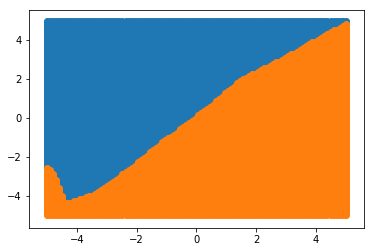

In [25]:
plt.scatter(X[Y_value==0,0],X[Y_value==0,1])
plt.scatter(X[Y_value==1,0],X[Y_value==1,1])

In [26]:
[np.mean(np.argmax(Yhat.eval(feed_dict={X_placeholder:D[idx][0]}),axis=1)==D[idx][1]) for idx in held_out_domain_idx]

[0.91100000000000003]

In [27]:
sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [28]:
n_input = 2
n_output = 2
n_hidden = 50

In [29]:
param_list = [tf.Variable(tf.truncated_normal(shape=[n_input, n_hidden], stddev=0.01)),
              tf.Variable(tf.zeros(shape=[n_hidden])),
              tf.Variable(tf.truncated_normal(shape=[n_hidden, n_output], stddev=0.01)),
              tf.Variable(tf.zeros(shape=[n_output]))]

def nn(x, W0, b0, W1, b1):
    h = tf.nn.xw_plus_b(x, W0, b0)
    a = tf.nn.relu(h)
    o = tf.nn.xw_plus_b(a, W1, b1)
    return o

In [30]:
X_placeholder_trn = tf.placeholder(tf.float32, shape=[None, n_input])
Y_placeholder_trn = tf.placeholder(tf.int32, shape=[None, n_output])
X_placeholder_val = tf.placeholder(tf.float32, shape=[None, n_input])
Y_placeholder_val = tf.placeholder(tf.int32, shape=[None, n_output])

In [31]:
Yhat_trn = nn(X_placeholder_trn, *param_list)
loss_trn = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Yhat_trn, labels=Y_placeholder_trn))

In [32]:
Yhat_val = nn(X_placeholder_val, *param_list)
loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Yhat_val, labels=Y_placeholder_val))

In [33]:
loss_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in tf.gradients(loss_val, param_list)])

In [34]:
observed_domain_idx = [0,1,2,3,4,5,6,7]
held_out_domain_idx = [8]

In [35]:
batch_size = 100
n_trn_domain = 4

In [36]:
loss_full = loss_trn + 1.5*loss_norm

In [37]:
opt = tf.train.AdamOptimizer(learning_rate=0.01)

In [38]:
train = opt.minimize(loss_full)

In [39]:
sess.run(tf.global_variables_initializer())

In [40]:
for outter_iteration in range(10):
    train_domain_idx = np.random.choice(observed_domain_idx, n_trn_domain, replace=False)
    validation_domain_idx = list(set(observed_domain_idx) - set(train_domain_idx))
    trnX = np.concatenate([D[i][0] for i in train_domain_idx], axis=0)
    trnY_tmp = np.concatenate([D[i][1] for i in train_domain_idx], axis=0)
    trnY = np.zeros((trnX.shape[0], n_output))
    trnY[np.arange(trnY.shape[0]),trnY_tmp] = 1
    valX = np.concatenate([D[i][0] for i in validation_domain_idx], axis=0)
    valY_tmp = np.concatenate([D[i][1] for i in validation_domain_idx], axis=0)
    valY = np.zeros((valX.shape[0], n_output))
    valY[np.arange(valY.shape[0]),valY_tmp] = 1
    n_sample_trn = trnX.shape[0]
    n_sample_val = valX.shape[0]
    for inner_iteration in range(1000):
        picked_idx_trn = np.random.choice(n_sample_trn, batch_size, replace=False)
        picked_idx_val = np.random.choice(n_sample_val, batch_size, replace=False)
        loss_trn_value, loss_norm_value, _ = sess.run([loss_trn,loss_norm, train], 
                                                      feed_dict={X_placeholder_trn:trnX[picked_idx_trn], 
                                                                 Y_placeholder_trn:trnY[picked_idx_trn],
                                                                 X_placeholder_val:valX[picked_idx_val], 
                                                                 Y_placeholder_val:valY[picked_idx_val]})
        if inner_iteration % 250 == 0:
            print(outter_iteration, loss_trn_value, loss_norm_value)

0 0.692498 0.0235497
0 0.693 0.00188327
0 0.683742 0.00653017
0 0.676234 0.0208742
1 0.199452 0.0112611
1 0.181934 0.0116074
1 0.228361 0.00705019
1 0.236106 0.0117511
2 0.273931 0.0311786
2 0.243031 0.0768674
2 0.160447 0.0467995
2 0.24147 0.02221
3 0.168767 0.0263965
3 0.197212 0.0967065
3 0.2192 0.00313634
3 0.288287 0.00417637
4 0.160579 0.00730122
4 0.240678 0.0173658
4 0.253575 0.00632997
4 0.231196 0.0140301
5 0.258032 0.0163952
5 0.169902 0.018857
5 0.239146 0.00507493
5 0.25689 0.0166946
6 0.216159 0.111508
6 0.139728 0.00670943
6 0.274319 0.0117566
6 0.175974 0.003512
7 0.272425 0.0702639
7 0.266465 0.0244165
7 0.244298 0.0115025
7 0.365526 0.0750261
8 0.269078 0.01771
8 0.222674 0.0417167
8 0.213269 0.0329166
8 0.192091 0.0203502
9 0.207296 0.0452816
9 0.262242 0.011119
9 0.208693 0.00777538
9 0.147171 0.000766399


In [41]:
Y_value = np.argmax(Yhat_trn.eval(feed_dict={X_placeholder_trn:X}),axis=1)

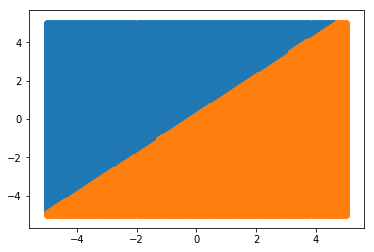

In [42]:
plt.scatter(X[Y_value==0,0],X[Y_value==0,1])
plt.scatter(X[Y_value==1,0],X[Y_value==1,1])

In [43]:
[np.mean(np.argmax(Yhat_trn.eval(feed_dict={X_placeholder_trn:D[idx][0]}),axis=1)==D[idx][1]) for idx in held_out_domain_idx]

[0.92179999999999995]